In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/sickle_toy_dataset.zip" -d "/content/sickle_toy_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/sickle_toy_dataset/images/S2/tif/659/20190628T050659_20190628T052051_T44PKS/20190628T050659_20190628T052051_T44PKS.SCL.tif  
  inflating: /content/sickle_toy_dataset/images/S2/tif/659/20190628T050659_20190628T052051_T44PKS/20190628T050659_20190628T052051_T44PKS.B11.tif  
  inflating: /content/sickle_toy_dataset/images/S2/tif/659/20190628T050659_20190628T052051_T44PKS/20190628T050659_20190628T052051_T44PKS.B7.tif  
  inflating: /content/sickle_toy_dataset/images/S2/tif/659/20190628T050659_20190628T052051_T44PKS/20190628T050659_20190628T052051_T44PKS.B8.tif  
  inflating: /content/sickle_toy_dataset/images/S2/tif/659/20190628T050659_20190628T052051_T44PKS/20190628T050659_20190628T052051_T44PKS.B5.tif  
  inflating: /content/sickle_toy_dataset/images/S2/tif/659/20190628T050659_20190628T052051_T44PKS/20190628T050659_20190628T052051_T44PKS.AOT.tif  
  inflating: /content/sickle_toy_dataset/images/S2/tif/659/20190628T05

In [3]:
import os


dataset_path = "/content/sickle_toy_dataset"


for root, dirs, files in os.walk(dataset_path):
    print("Root:", root)
    print("Directories:", dirs)

    print("-" * 20)

Streaming output truncated to the last 5000 lines.
Directories: []
--------------------
Root: /content/sickle_toy_dataset/images/S2/tif/1344/20200905T050701_20200905T052025_T44PKT
Directories: []
--------------------
Root: /content/sickle_toy_dataset/images/S2/tif/1344/20200925T050701_20200925T051443_T44PKT
Directories: []
--------------------
Root: /content/sickle_toy_dataset/images/S2/tif/1344/20201114T051051_20201114T051811_T44PKT
Directories: []
--------------------
Root: /content/sickle_toy_dataset/images/S2/tif/1344/20201231T050221_20201231T050216_T44PKT
Directories: []
--------------------
Root: /content/sickle_toy_dataset/images/S2/tif/1344/20200902T045701_20200902T050522_T44PKT
Directories: []
--------------------
Root: /content/sickle_toy_dataset/images/S2/tif/1344/20210105T050209_20210105T050811_T44PKT
Directories: []
--------------------
Root: /content/sickle_toy_dataset/images/S2/tif/1344/20200917T045659_20200917T051352_T44PKT
Directories: []
--------------------
Root: /co

In [4]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 15.4 MB/s eta 0:00:00


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import rasterio

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define UNet first
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1), nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

torch.cuda.empty_cache()
model = UNet().to(device)
print("Model initialized on GPU")

# Dataset
class SICKLEDataset(Dataset):
    def __init__(self, image_root, mask_root, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.transform = transform
        self.band_mapping = {"L8": ["SR_B2", "SR_B3", "SR_B4"], "S2": ["B2", "B3", "B4"], "S1": ["VV", "VH"]}
        for source in self.band_mapping.keys():
            image_dir = os.path.join(image_root, source, "npy")
            mask_dir = os.path.join(mask_root, "10m")
            if not os.path.exists(image_dir):
                print(f"Skipping missing directory: {image_dir}")
                continue
            for folder in os.listdir(image_dir):
                image_folder = os.path.join(image_dir, folder)
                mask_file = os.path.join(mask_dir, f"{folder}.tif")
                if not os.path.exists(mask_file):
                    print(f"Skipping missing mask: {mask_file}")
                    continue
                for file in os.listdir(image_folder):
                    if file.endswith(".npz"):
                        self.image_paths.append((source, os.path.join(image_folder, file)))
                        self.mask_paths.append(mask_file)
        print(f"Total images: {len(self.image_paths)}, Total masks: {len(self.mask_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        source, npz_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        npz_data = np.load(npz_path)
        available_keys = list(npz_data.keys())
        selected_bands = self.band_mapping[source]
        if not all(b in available_keys for b in selected_bands):
            return None
        image_bands = [npz_data[b] for b in selected_bands]
        image = np.stack(image_bands, axis=-1)
        if image.shape[-1] == 2:
            image = np.pad(image, ((0, 0), (0, 0), (0, 1)), mode='constant')
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 65535.0
        with rasterio.open(mask_path) as src:
            mask = torch.tensor(src.read(1), dtype=torch.float32).unsqueeze(0)
            mask = mask / 255.0 if mask.max() > 1.0 else mask
        image = F.interpolate(image.unsqueeze(0), size=(128, 128), mode="bilinear", align_corners=False).squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0), size=(128, 128), mode="nearest").squeeze(0)
        image = image[:3, :, :]
        mask = mask[:1, :, :]
        return image, mask

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None
    images, masks = zip(*batch)
    return torch.stack(images), torch.stack(masks)

image_root = "/content/sickle_toy_dataset/images"
mask_root = "/content/sickle_toy_dataset/masks"
dataset = SICKLEDataset(image_root, mask_root)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda b: collate_fn(b) or [])

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.clamp(outputs, 0, 1)
        masks = torch.clamp(masks, 0, 1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}")

Using device: cuda
Model initialized on GPU
Total images: 19859, Total masks: 19859


100%|██████████| 4965/4965 [02:55<00:00, 28.23it/s]


Epoch 1/5, Loss: 0.10306174528615292


100%|██████████| 4965/4965 [02:54<00:00, 28.48it/s]


Epoch 2/5, Loss: 0.10037216364114367


100%|██████████| 4965/4965 [02:57<00:00, 27.96it/s]


Epoch 3/5, Loss: 0.10021914962532837


100%|██████████| 4965/4965 [02:53<00:00, 28.54it/s]


Epoch 4/5, Loss: 0.09996464204339522


100%|██████████| 4965/4965 [02:57<00:00, 27.97it/s]

Epoch 5/5, Loss: 0.09981382567011578


In [6]:


def test_and_show_accuracy(model, dataloader, device, criterion):
    """
    Tests the model on the provided dataloader and displays the accuracy.

    Args:
        model: The trained PyTorch model.
        dataloader: The DataLoader for the test dataset.
        device: The device (CPU or GPU) to use for testing.
        criterion: The loss function used for evaluation.
    """

    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            outputs = torch.clamp(outputs, 0, 1)
            masks = torch.clamp(masks, 0, 1)

            loss = criterion(outputs, masks)
            running_loss += loss.item()

            predicted_masks = (outputs > 0.5).float()
            correct_pixels += (predicted_masks == masks).sum().item()
            total_pixels += masks.numel()

    accuracy = correct_pixels / total_pixels
    average_loss = running_loss / len(dataloader)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Average Test Loss: {average_loss:.4f}")




In [7]:





test_size = int(0.2 * len(dataset))
test_dataset, _ = torch.utils.data.random_split(dataset, [test_size, len(dataset) - test_size])


test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda b: collate_fn(b) or [])






test_and_show_accuracy(model, test_dataloader, device, criterion)


100%|██████████| 993/993 [00:33<00:00, 29.59it/s]

Test Accuracy: 0.9649
Average Test Loss: 0.0979


In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import rasterio

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_channels)
    )

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.encoder = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 64),
            nn.MaxPool2d(2, 2),
            conv_block(64, 128),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            conv_block(128, 64),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            conv_block(64, 32),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(32, 1, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

customcnn_model = CustomCNN().to(device)
print("Custom model initialized on GPU")

torch.cuda.empty_cache()



image_root = "/content/sickle_toy_dataset/images"
mask_root = "/content/sickle_toy_dataset/masks"
dataset = SICKLEDataset(image_root, mask_root)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda b: collate_fn(b) or [])

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.clamp(outputs, 0, 1)
        masks = torch.clamp(masks, 0, 1)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader)}")


Using device: cuda
Custom model initialized on GPU
Total images: 19859, Total masks: 19859


100%|██████████| 4965/4965 [02:54<00:00, 28.53it/s]


Epoch 1/5, Loss: 0.09968240709988492


100%|██████████| 4965/4965 [02:52<00:00, 28.83it/s]


Epoch 2/5, Loss: 0.09954928804642904


100%|██████████| 4965/4965 [02:51<00:00, 28.96it/s]


Epoch 3/5, Loss: 0.0995161719785296


100%|██████████| 4965/4965 [02:53<00:00, 28.55it/s]


Epoch 4/5, Loss: 0.09949282802536348


100%|██████████| 4965/4965 [02:49<00:00, 29.31it/s]

Epoch 5/5, Loss: 0.09948148561710977


In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import rasterio
import matplotlib.pyplot as plt  # <- Add this line


100%|██████████| 993/993 [00:24<00:00, 41.32it/s]



Model Comparisons:
U-Net Accuracy: 0.9649, Loss: 0.0972
CustomCNN Accuracy: 0.9649, Loss: 0.6860


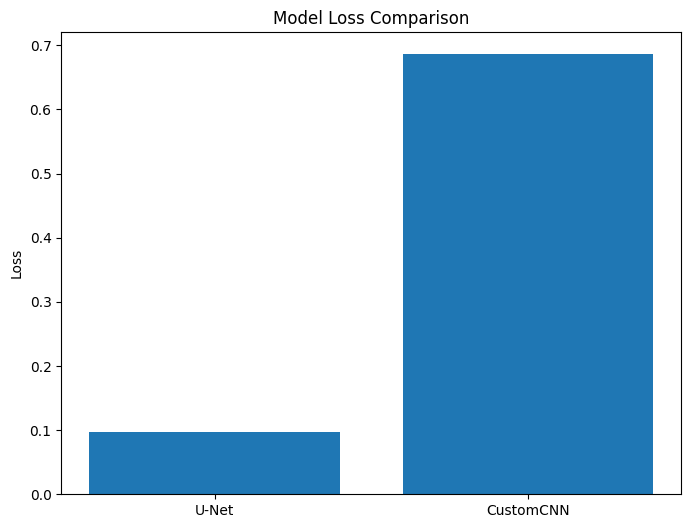

In [10]:


def test_models_and_compare(unet_model, customcnn_model, test_dataloader, device, criterion):
    """
    Tests both the U-Net and CustomCNN models on the test dataloader,
    calculates accuracy and loss, and displays comparisons.

    Args:
        unet_model: The trained U-Net model.
        customcnn_model: The trained CustomCNN model.
        test_dataloader: The DataLoader for the test dataset.
        device: The device (CPU or GPU) to use for testing.
        criterion: The loss function used for evaluation.
    """

    def evaluate_model(model, dataloader, device, criterion):
        model.eval()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        with torch.no_grad():
            for images, masks in tqdm(dataloader):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = torch.clamp(outputs, 0, 1)
                masks = torch.clamp(masks, 0, 1)
                loss = criterion(outputs, masks)
                running_loss += loss.item()
                predicted_masks = (outputs > 0.5).float()
                correct_pixels += (predicted_masks == masks).sum().item()
                total_pixels += masks.numel()

        accuracy = correct_pixels / total_pixels
        average_loss = running_loss / len(dataloader)
        return accuracy, average_loss

    unet_accuracy, unet_loss = evaluate_model(unet_model, test_dataloader, device, criterion)
    customcnn_accuracy, customcnn_loss = evaluate_model(customcnn_model, test_dataloader, device, criterion)

    print("\nModel Comparisons:")
    print(f"U-Net Accuracy: {unet_accuracy:.4f}, Loss: {unet_loss:.4f}")
    print(f"CustomCNN Accuracy: {customcnn_accuracy:.4f}, Loss: {customcnn_loss:.4f}")


    '''
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.bar(["U-Net", "CustomCNN"], [unet_accuracy, customcnn_accuracy])
    plt.title("Model Accuracy Comparison")
    plt.ylabel("Accuracy")
    plt.show()
   '''

    plt.figure(figsize=(8, 6))
    plt.bar(["U-Net", "CustomCNN"], [unet_loss, customcnn_loss])
    plt.title("Model Loss Comparison")
    plt.ylabel("Loss")
    plt.show()


test_models_and_compare(model, customcnn_model, test_dataloader, device, criterion)



In [11]:
!pip install torchvision
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 843.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm



In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained DeepLabV3 model
deeplab_model = models.segmentation.deeplabv3_resnet50(pretrained=True)

# Modify the classifier to output 1 channel for binary segmentation
deeplab_model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
deeplab_model.classifier.add_module("sigmoid", nn.Sigmoid())

# Move model to the specified device (GPU if available, otherwise CPU)
deeplab_model = deeplab_model.to(device)
print("DeepLabV3 model initialized for binary segmentation.")




Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 165MB/s]


DeepLabV3 model initialized for binary segmentation.


In [14]:
def train_deeplab(model, dataloader, optimizer, criterion, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, masks in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)['out']  # Important: access 'out'
            outputs = torch.clamp(outputs, 0, 1)
            masks = torch.clamp(masks, 0, 1)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(dataloader):.4f}")



In [15]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            outputs = torch.clamp(outputs, 0, 1)
            masks = torch.clamp(masks, 0, 1)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            predicted_masks = (outputs > 0.5).float()
            correct_pixels += (predicted_masks == masks).sum().item()
            total_pixels += masks.numel()

    accuracy = correct_pixels / total_pixels
    avg_loss = total_loss / len(dataloader)

    print(f"DeepLabV3 Test Accuracy: {accuracy:.4f}")
    print(f"DeepLabV3 Average Loss: {avg_loss:.4f}")


In [16]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(deeplab_model.parameters(), lr=0.001)

# Train the model
train_deeplab(deeplab_model, dataloader, optimizer, criterion, device, epochs=5)

# Evaluate on test data
evaluate_model(deeplab_model, test_dataloader, criterion)


Epoch 1/5: 100%|██████████| 4965/4965 [12:20<00:00,  6.70it/s]


Epoch 1/5, Loss: 0.0994


Epoch 2/5: 100%|██████████| 4965/4965 [12:18<00:00,  6.73it/s]


Epoch 2/5, Loss: 0.0974


Epoch 3/5: 100%|██████████| 4965/4965 [12:16<00:00,  6.74it/s]


Epoch 3/5, Loss: 0.0972


Epoch 4/5: 100%|██████████| 4965/4965 [12:15<00:00,  6.75it/s]


Epoch 4/5, Loss: 0.0972


Epoch 5/5: 100%|██████████| 4965/4965 [12:16<00:00,  6.74it/s]


Epoch 5/5, Loss: 0.0971


Evaluating: 100%|██████████| 993/993 [01:00<00:00, 16.49it/s]

DeepLabV3 Test Accuracy: 0.9649
DeepLabV3 Average Loss: 0.1559


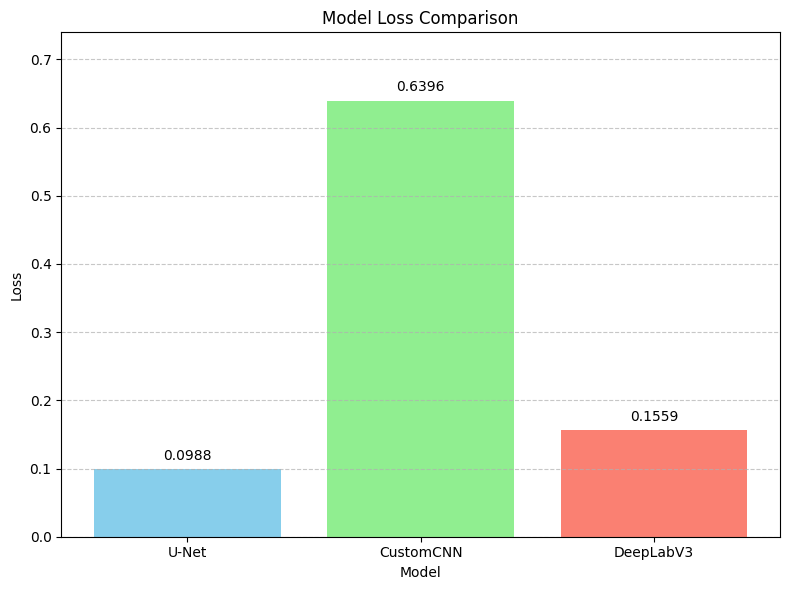

In [18]:
import matplotlib.pyplot as plt

# Updated losses
unet_loss = 0.0988
customcnn_loss = 0.6396
deeplabv3_loss = 0.1559  # ← Updated loss for DeepLabV3

# Labels and values
models = ['U-Net', 'CustomCNN', 'DeepLabV3']
loss_values = [unet_loss, customcnn_loss, deeplabv3_loss]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(models, loss_values, color=['skyblue', 'lightgreen', 'salmon'])

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height:.4f}', ha='center', va='bottom')

plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Model')
plt.ylim(0, max(loss_values) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [20]:
!pip install segmentation-models-pytorch
!pip install pretrainedmodels
!pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 10.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=5e55031d7359ebacd0e144d68e27e1a25cc46ca7af05586b5e83d6ee595a173c
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=fabf754ea30fe09393d450d9e62e3a8fe64af75fa5135ead756d9f39f939e677
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels


In [21]:
!pip install timm


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import segmentation_models_pytorch as smp

# Use the same dataset and collate_fn you've already defined earlier
# Assuming: dataset, test_dataloader, SICKLEDataset, collate_fn already exist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model - EfficientNet B0 as encoder + Unet decoder
effnet_model = smp.Unet(
    encoder_name="efficientnet-b0",        # EfficientNet as encoder
    encoder_weights="imagenet",            # use pretrained weights
    in_channels=3,                         # input channels (RGB)
    classes=1,                             # binary segmentation
    activation="sigmoid"                   # for BCE loss
).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(effnet_model.parameters(), lr=0.001)

# DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda b: collate_fn(b) or [])

# Train function
def train_model(model, dataloader, optimizer, criterion, device, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = torch.clamp(outputs, 0, 1)
            masks = torch.clamp(masks, 0, 1)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(dataloader):.4f}")

# Train EfficientNet model
train_model(effnet_model, dataloader, optimizer, criterion, device, epochs=5)

# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            outputs = torch.clamp(outputs, 0, 1)
            masks = torch.clamp(masks, 0, 1)
            loss = criterion(outputs, masks)
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct_pixels += (predicted == masks).sum().item()
            total_pixels += masks.numel()

    accuracy = correct_pixels / total_pixels
    avg_loss = running_loss / len(dataloader)
    print(f"EfficientNet Accuracy: {accuracy:.4f}, Loss: {avg_loss:.4f}")
    return accuracy, avg_loss

# Evaluate EfficientNet
effnet_accuracy, effnet_loss = evaluate_model(effnet_model, test_dataloader, criterion, device)


Using device: cuda


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 137MB/s] 
100%|██████████| 4965/4965 [10:31<00:00,  7.86it/s]


Epoch 1/5, Loss: 0.1007


100%|██████████| 4965/4965 [10:17<00:00,  8.05it/s]


Epoch 2/5, Loss: 0.0967


100%|██████████| 4965/4965 [10:18<00:00,  8.02it/s]


Epoch 3/5, Loss: 0.0945


100%|██████████| 4965/4965 [10:24<00:00,  7.96it/s]


Epoch 4/5, Loss: 0.0877


100%|██████████| 4965/4965 [10:06<00:00,  8.18it/s]


Epoch 5/5, Loss: 0.0824


100%|██████████| 993/993 [00:50<00:00, 19.85it/s]

EfficientNet Accuracy: 0.9647, Loss: 0.0776


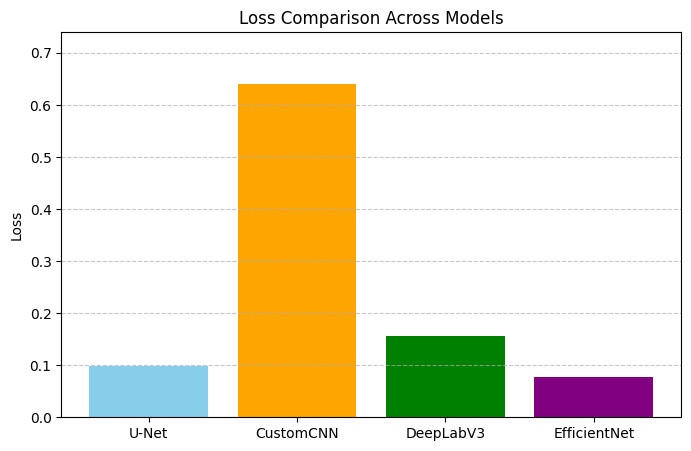

In [23]:
import matplotlib.pyplot as plt

# Replace these with your actual values
losses = [0.0988, 0.6396, 0.1559, 0.0776]
models = ['U-Net', 'CustomCNN', 'DeepLabV3', 'EfficientNet']

plt.figure(figsize=(8, 5))
plt.bar(models, losses, color=['skyblue', 'orange', 'green', 'purple'])
plt.ylabel("Loss")
plt.title("Loss Comparison Across Models")
plt.ylim(0, max(losses) + 0.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
